# Описание признаков 

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту


# Импорт библиотек

In [14]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
from math import log as log
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None
from sklearn.metrics import auc, roc_auc_score, roc_curve

# Загрузка данных 

In [15]:
# тренировочный набор
data = pd.read_csv('train.csv')
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [16]:
# тестовый набор
data_test = pd.read_csv('test.csv')
data_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


# Создание функций

Функция поисков выбросов до логорифмирования

In [17]:
def iqr_before(name):
    median = df[name].median()
    IQR = df[name].quantile(0.75) - df[name].quantile(0.25)
    perc25 = df[name].quantile(0.25)
    perc75 = df[name].quantile(0.75)
    print('Границы до логорифмирования')
    print('25-й перцентиль: {},'.format(perc25)) 
    print('75-й перцентиль: {},'.format(perc75))
    print("IQR: {}, ".format(IQR))
    print("Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    f=perc25 - 1.5*IQR
    l=perc75 + 1.5*IQR
    out = df[(df[name]<f)|(df[name]>l)][name].count()
    print('Количество выбросов {}'.format(out))

Функция поисков выбросов после логорифмирования

In [18]:
def iqr_after(name):
    median = df[name].median()
    IQR = df[name].quantile(0.75) - df[name].quantile(0.25)
    perc25 = df[name].quantile(0.25)
    perc75 = df[name].quantile(0.75)
    print('Границы до логорифмирования')
    print('25-й перцентиль: {},'.format(perc25)) 
    print('75-й перцентиль: {},'.format(perc75))
    print("IQR: {}, ".format(IQR))
    print("Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    f=perc25 - 1.5*IQR
    l=perc75 + 1.5*IQR
    out = df[(df[name]<f)|(df[name]>l)][name].count()
    print('Количество выбросов {}'.format(out))

Ниже добавлены функции с просторов интернета, для экономии времени.

Указанные функции необходимы для проведения оценки модели 

In [19]:
def show_confusion_matrix(y_true, y_pred):
    """Функция отображает confusion-матрицу"""
    color_text = plt.get_cmap('GnBu')(1.0)
    class_names = ['Дефолт', 'НЕ дефолт']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Матрица ошибок")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="GnBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Реальные значения', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()
    
    
def all_metrics(y_true, y_pred, y_pred_prob):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['P'] = [P,'Дефолт']
    dict_metric['N'] = [N,'БЕЗ дефолта']
    dict_metric['TP'] = [TP,'Истинно дефолтные']
    dict_metric['TN'] = [TN,'Истинно НЕ дефолтные']
    dict_metric['FP'] = [FP,'Ложно дефолтные']
    dict_metric['FN'] = [FN,'Ложно НЕ дефолтные']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Точность = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Полнота = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC-AUC']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df) 

def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

НАБОР ДАННЫХ

Посмотрим форму данных, их состав и пропуски

Объединим тестовый и тренировочный наборы

In [20]:
data['train'] = 1
data_test['train'] = 0
df = data.append(data_test, sort=False).reset_index(drop=True)
testing = df

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
client_id           110148 non-null int64
app_date            110148 non-null object
education           109670 non-null object
sex                 110148 non-null object
age                 110148 non-null int64
car                 110148 non-null object
car_type            110148 non-null object
decline_app_cnt     110148 non-null int64
good_work           110148 non-null int64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null int64
region_rating       110148 non-null int64
home_address        110148 non-null int64
work_address        110148 non-null int64
income              110148 non-null int64
sna                 110148 non-null int64
first_time          110148 non-null int64
foreign_passport    110148 non-null object
default             73799 non-null float64
train               110148 non-null int64
dtypes: float64(2), int64(12), object(6)

Видим, что данные содержат как числовые, так и не числовые признаки. Количество строк 110148

In [22]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

Колонка education в общем наборе имеет 478 пропусков. В последствии заменим их на None, чтоб не терять данные.

Посмотрим наименования всех колонок

In [23]:
df.columns

Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
       'region_rating', 'home_address', 'work_address', 'income', 'sna',
       'first_time', 'foreign_passport', 'default', 'train'],
      dtype='object')

Пройдя циклом по столбцам можем выделить признаки, которые могут быть онесены к бинарным,категориальным, числовым или же содержащие метки времени

In [24]:
step = 1
for i in df.columns:
    print(i)
    print(df[i].value_counts())
    step +=1

client_id
2047     1
97541    1
93447    1
70920    1
72969    1
        ..
47810    1
45763    1
35524    1
33477    1
2049     1
Name: client_id, Length: 110148, dtype: int64
app_date
18MAR2014    1491
19MAR2014    1363
17MAR2014    1350
31MAR2014    1317
07APR2014    1296
             ... 
20APR2014     359
07JAN2014     349
03JAN2014     313
02JAN2014     204
01JAN2014      56
Name: app_date, Length: 120, dtype: int64
education
SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64
sex
F    61836
M    48312
Name: sex, dtype: int64
age
31    4084
28    4035
30    4035
27    3964
29    3940
26    3780
32    3773
34    3548
33    3499
35    3386
25    3292
36    3228
37    3185
39    3095
38    3070
40    2950
42    2857
41    2804
24    2780
43    2672
44    2536
23    2295
45    2235
50    2104
46    2102
48    2084
47    2074
52    2065
51    2015
53    1980
49    1964
54    1911
55    1837
56    1641
57    1578
22    1415
58    1373
59    13

Колонки имеющие всего два значения могут быть отнесены к бинарным. Имеющие более двух, но содержащие наименования (к примеру указание грейдов обучения), отнесем к категориальным. Содержащие численные значение - к числовым.

Избавимся сперва от пропусков в education

In [25]:
df['education'] = df['education'].fillna('None')

In [26]:
#проверяем - пропусков нет
df.isna().sum()

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

Пропуски в колонке default относятся к тестовому набору

Общий вид набора данных

In [27]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


# Feature engineering 

Посмотрим, какие новые данные можем получить из тех, которые уже имеем

Есть две переменные - decline_app_cnt (количество отказов) и bki_request_cnt (количество запросов в БКИ). Очевидно, что разница двух этих значений может указывать на тот факт, что решение по отказу принималось сразу в банке по месту, по разного рода причинам. Проверим...

In [28]:
df['request_difference'] = df['decline_app_cnt'] - df['bki_request_cnt']


In [29]:
df[['decline_app_cnt','bki_request_cnt']]

,decline_app_cnt,bki_request_cnt
0,0,1
1,0,3
2,2,1
3,0,2
4,0,1
...,...,...
110143,1,3
110144,0,3
110145,2,1
110146,1,2


Оставим новый признак request_difference в качестве категориального

In [30]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,request_difference
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,...,50,1,2,18000,4,1,N,0.0,1,-1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,...,50,2,3,19000,4,1,N,0.0,1,-3
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,...,80,1,2,30000,1,4,Y,0.0,1,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,...,50,2,3,10000,1,3,N,0.0,1,-2
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,...,60,2,3,30000,1,4,Y,0.0,1,-1


Выделим основные группы признаков: бинарные, числовые, категориальные и временные метки.

колонка client_id смысловой нагрузки не несет, поэтому использовать её не будем.

Добавим новый признак в категориальные.

In [31]:
#бинарные признаки
bin_cols = ['sex','car','car_type','good_work','foreign_passport']
#категориальные признаки
cat_cols = ['education','home_address','work_address', 'first_time', 'sna','region_rating','request_difference']
#числовые признаки
num_cols = ['age','income','score_bki']
#временные метки
time_cols = ['app_date']

# Визуализация признаков 

### 1. AGE

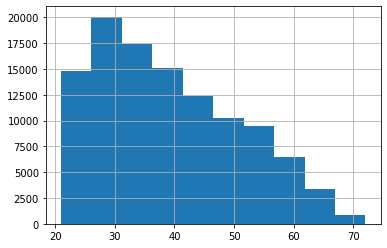

In [32]:
df['age'].hist()

Согласно распределению видим, что больше всего в выборке людей среднего возраста

In [33]:
# прологирфируем, чтоб получить более нормальное распределение
df['age'] = np.log(df['age']+1)

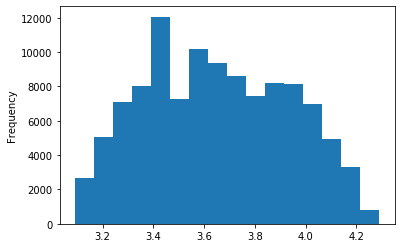

In [34]:
df['age'].plot.hist(bins=16)

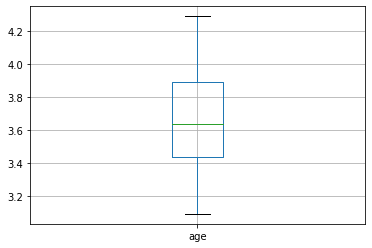

In [35]:
boxplot = df.boxplot(column = 'age')

Выбросов в столбце возраста не наблюдаем

### 2. CAR - наличие автомобиля

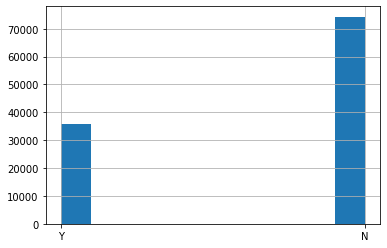

In [36]:
df['car'].hist()

В наборе данных больше тех, кто не имеет машины.

### 3. сar_type - наличие иностранного автомобиля

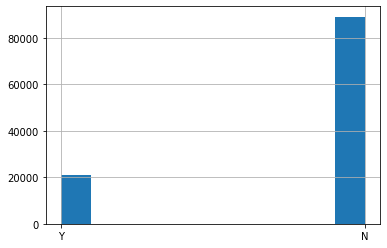

In [37]:
df['car_type'].hist()

У большинства автомобили отечественного производства

### 4. decline_app_cnt - количество отказанных прошлых заявок

Для отображения зададим дипазон значений больше 0, чтоб отсеить тех, кто не имел отказов. 

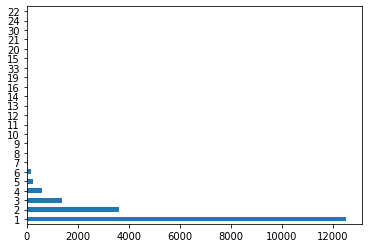

In [38]:
df.query('0<decline_app_cnt')['decline_app_cnt'].value_counts().plot.barh()

Видим, что есть люди, имеющие много отказов, вплоть до 33.

In [39]:
df['decline_app_cnt'].max()

33

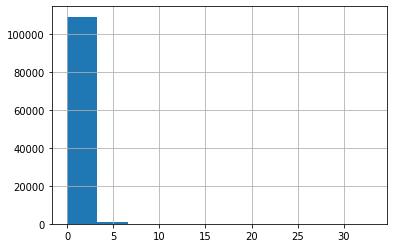

In [40]:
df['decline_app_cnt'].hist(bins = 10)

In [41]:
iqr_before('decline_app_cnt')

Границы до логорифмирования
25-й перцентиль: 0.0,
75-й перцентиль: 0.0,
IQR: 0.0, 
Границы выбросов: [0.0, 0.0].
Количество выбросов 18677


Прологорифмируем

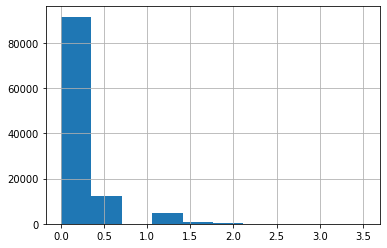

In [42]:
df['decline_app_cnt'] = np.log(df['decline_app_cnt']+1)
df['decline_app_cnt'].hist(bins = 10)

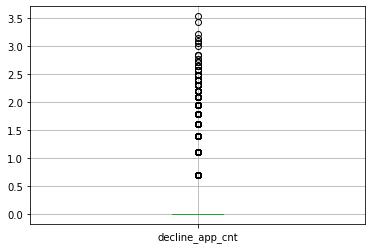

In [43]:
df.boxplot(column = 'decline_app_cnt')

По boxplot видны выбросы.

In [44]:
iqr_after('decline_app_cnt')

Границы до логорифмирования
25-й перцентиль: 0.0,
75-й перцентиль: 0.0,
IQR: 0.0, 
Границы выбросов: [0.0, 0.0].
Количество выбросов 18677


Данная колонка не интересна, так как входит в состав нового признака и только добавит линейности

### 5. request_difference

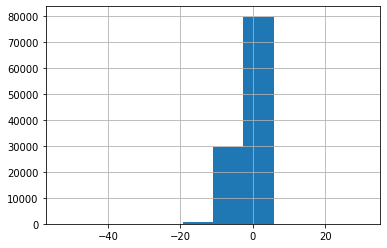

In [45]:
df['request_difference'].hist()

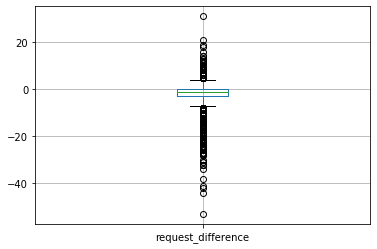

In [46]:
df.boxplot(column = 'request_difference')

Посмотрим границы выбросов до логорифмирования

In [47]:
iqr_before('request_difference')

Границы до логорифмирования
25-й перцентиль: -3.0,
75-й перцентиль: 0.0,
IQR: 3.0, 
Границы выбросов: [-7.5, 4.5].
Количество выбросов 2407


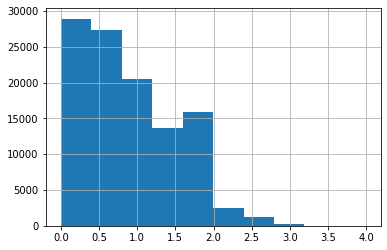

In [48]:
df['request_difference'] = np.log(df['bki_request_cnt']+1)
df['request_difference'].hist(bins = 10)

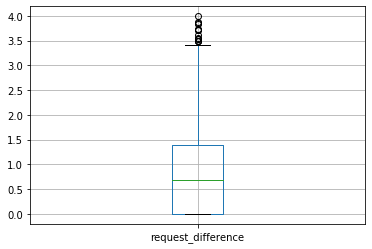

In [49]:
df.boxplot(column = 'request_difference')

Аналогичным образом для запросов заметны выбросы. Их количество мало, поэтому не будем обращать на них внимания

In [50]:
iqr_after('request_difference')

Границы до логорифмирования
25-й перцентиль: 0.0,
75-й перцентиль: 1.3862943611198906,
IQR: 1.3862943611198906, 
Границы выбросов: [-2.0794415416798357, 3.465735902799726].
Количество выбросов 15


### 6. Income

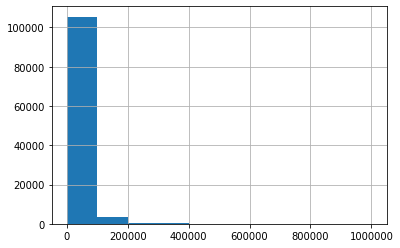

In [51]:
df['income'].hist()

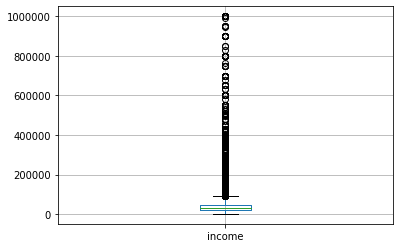

In [52]:
df.boxplot(column = 'income')

In [53]:
iqr_before('income')

Границы до логорифмирования
25-й перцентиль: 20000.0,
75-й перцентиль: 48000.0,
IQR: 28000.0, 
Границы выбросов: [-22000.0, 90000.0].
Количество выбросов 7000


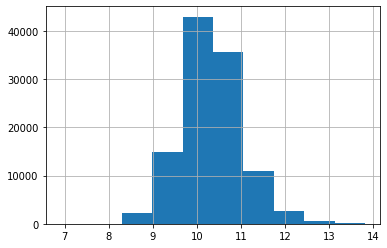

In [54]:
df['income'] = np.log(df['income']+1)
df['income'].hist(bins = 10)

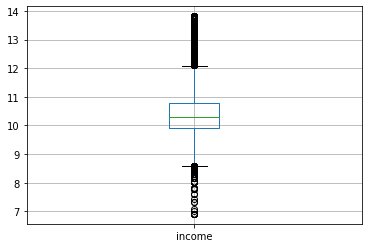

In [55]:
df.boxplot(column = 'income')

In [56]:
iqr_after('income')

Границы до логорифмирования
25-й перцентиль: 9.90353755128617,
75-й перцентиль: 10.778977123006351,
IQR: 0.8754395717201806, 
Границы выбросов: [8.590378193705899, 12.092136480586621].
Количество выбросов 2609


Признак income имеет 2609 выбросов. Удалим их чуть позже, чтоб не оказывали влияния

### 7. Score_bki

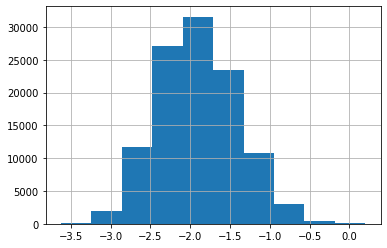

In [57]:
df['score_bki'].hist()

In [58]:
iqr_before('score_bki')

Границы до логорифмирования
25-й перцентиль: -2.2604336700000003,
75-й перцентиль: -1.5678881525,
IQR: 0.6925455175000004, 
Границы выбросов: [-3.299251946250001, -0.5290698762499992].
Количество выбросов 518


### 8. SNA

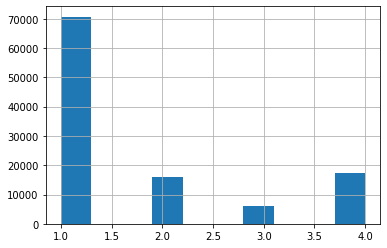

In [59]:
df['sna'].hist()

In [60]:
df.sna.value_counts()

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

### 9. first_time - давность наличия информации о заемщике

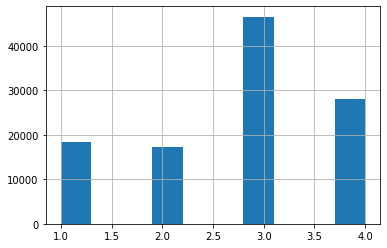

In [61]:
df.first_time.hist()

In [62]:
df.first_time.value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

### 10. Region rating

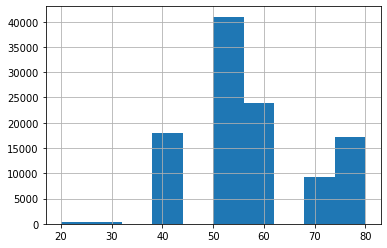

In [63]:
df.region_rating.hist()

In [64]:
iqr_before('region_rating')

Границы до логорифмирования
25-й перцентиль: 50.0,
75-й перцентиль: 60.0,
IQR: 10.0, 
Границы выбросов: [35.0, 75.0].
Количество выбросов 17917


Большое количество выбросов. Однако этот признак тесно связан с признаком income и, при удалении выбросов последнего, уменьшится количество собственных.

К тому же этот признак после анализа отнесен был к категориальным, а не числовым.

### 11.Education

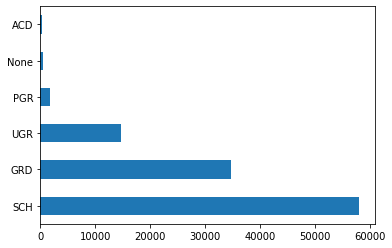

In [65]:
df.education.value_counts().plot.barh()

Пока не будем заменять None на самое распространненное значения, проверим модель так.

### 12. app_date - временная метка

In [66]:
df.app_date = pd.to_datetime(df.app_date, format='%d%b%Y')

In [67]:
start = df.app_date.min()
end = df.app_date.max()
print(start,end)

2014-01-01 00:00:00 2014-04-30 00:00:00


In [68]:
df['days'] = (df.app_date - start).dt.days.astype('int')

In [69]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,train,request_difference,days
0,25905,2014-02-01,SCH,M,4.143135,Y,Y,0.000000,0,-2.008753,...,1,2,9.798183,4,1,N,0.0,1,0.693147,31
1,63161,2014-03-12,SCH,F,4.094345,N,N,0.000000,0,-1.532276,...,2,3,9.852247,4,1,N,0.0,1,1.386294,70
2,25887,2014-02-01,SCH,M,3.258097,Y,N,1.098612,0,-1.408142,...,1,2,10.308986,1,4,Y,0.0,1,0.693147,31
3,16222,2014-01-23,SCH,F,3.988984,N,N,0.000000,0,-2.057471,...,2,3,9.210440,1,3,N,0.0,1,1.098612,22
4,101655,2014-04-18,GRD,M,3.891820,N,N,0.000000,1,-1.244723,...,2,3,10.308986,1,4,Y,0.0,1,0.693147,107


In [70]:
df['days'] = np.log(df['days']+1)

In [71]:
num_cols.append('days')
num_cols

['age', 'income', 'score_bki', 'days']

# Оценка корреляций

In [72]:
default = ['default']
corr_col = num_cols+default
corr_matrix = df[corr_col].corr(method = 'pearson')

In [73]:
corr_matrix

,age,income,score_bki,days,default
age,1.000000,-0.090734,-0.109169,0.019532,-0.026119
income,-0.090734,1.000000,0.002592,-0.004309,-0.053871
score_bki,-0.109169,0.002592,1.000000,-0.053026,0.175369
days,0.019532,-0.004309,-0.053026,1.000000,-0.034399
default,-0.026119,-0.053871,0.175369,-0.034399,1.000000


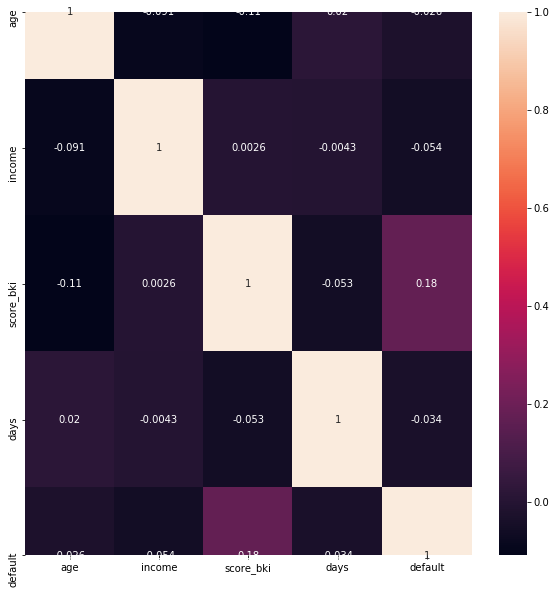

In [74]:
plt.figure(figsize=(10,10)) # размер графика
sns.heatmap(data = corr_matrix, annot=True)

В матрице корреляций не осталось каких либо признаков с критически сильным влиянием на целевую переменную

### Значимость числовых признаков (F test)

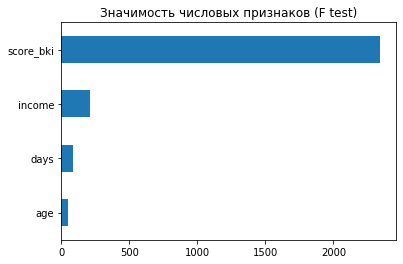

In [75]:
temp_df = df[df['train']==1]
imp_num = pd.Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость числовых признаков (F test)')

Самый значимый признак из числовых - score_bki, что, в принципе, очевидно.

### Категориальный и бинарные переменные

Преобразуем бинарные переменные в понятный формат 1,0

In [76]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,train,request_difference,days
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,...,1,2,9.798183,4,1,0,0.0,1,0.693147,3.465736
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,...,2,3,9.852247,4,1,0,0.0,1,1.386294,4.262680
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,...,1,2,10.308986,1,4,1,0.0,1,0.693147,3.465736
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,...,2,3,9.210440,1,3,0,0.0,1,1.098612,3.135494
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,...,2,3,10.308986,1,4,1,0.0,1,0.693147,4.682131


Преобразуем категориальный признак education. Получим пять категорий от 0 до 5

In [77]:
edu_label_encoder = LabelEncoder()
df['education'] = edu_label_encoder.fit_transform(df['education'])

In [78]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,home_address,work_address,income,sna,first_time,foreign_passport,default,train,request_difference,days
0,25905,2014-02-01,4,1,4.143135,1,1,0.000000,0,-2.008753,...,1,2,9.798183,4,1,0,0.0,1,0.693147,3.465736
1,63161,2014-03-12,4,0,4.094345,0,0,0.000000,0,-1.532276,...,2,3,9.852247,4,1,0,0.0,1,1.386294,4.262680
2,25887,2014-02-01,4,1,3.258097,1,0,1.098612,0,-1.408142,...,1,2,10.308986,1,4,1,0.0,1,0.693147,3.465736
3,16222,2014-01-23,4,0,3.988984,0,0,0.000000,0,-2.057471,...,2,3,9.210440,1,3,0,0.0,1,1.098612,3.135494
4,101655,2014-04-18,1,1,3.891820,0,0,0.000000,1,-1.244723,...,2,3,10.308986,1,4,1,0.0,1,0.693147,4.682131


In [79]:
df['education'].value_counts()

4    57998
1    34768
5    14748
3     1865
2      478
0      291
Name: education, dtype: int64

Для оценки значимости категориальных и бинарных переменных используем mutual_info_class

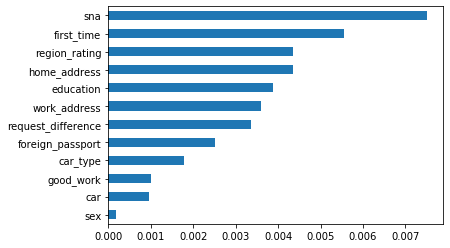

In [80]:
df_train = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(df_train[bin_cols + cat_cols], df_train['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

SNA - связь заемщика с клиентами банка является наиболее влиятельным признаком, как и актуальность информация о заемщике.Пол, по большому счёту, роли особой не играет.

# Подготовка данных к ML

In [81]:
# из общего набора данных выделим тестовый, 
#чтоб в дальнейшем использовать для submission
test_for_sub = df.query('train == 0').drop(['train'], axis=1)
id_test = test_for_sub.client_id

In [82]:
id_test.shape

(36349,)

Удаляем выбросы income в соответсвии с границами

In [83]:
df = df[(df['income']>8.59)&(df['income']<12.09)]

### Стандартизируем признаки

Для стандартизации будем использовать OneHotEncoder

In [84]:
X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

In [85]:
# df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

Стандартизируем числовые переменные:

In [86]:
# df.drop(['app_date', 'client_id'], axis=1, inplace=True)

In [87]:
X_num = StandardScaler().fit_transform(df[num_cols].values)

Объединяем

In [88]:
X = np.hstack([X_num, df[bin_cols].values, X_cat])
Y = df['default'].values

In [89]:
X_cat.shape

(107539, 31)

Разделяем набор данных для обучения модели

In [90]:
train_data = df.query('train == 1').drop(['train'], axis=1)
test_data = df.query('train == 0').drop(['train'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [91]:
test_data.shape

(35507, 21)

# 1. Модель без гиперпараметров

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((35507, 21), (72032, 21), (72032, 20), (57625, 20), (14407, 20))

In [94]:
# id_test = X_test.client_id

In [95]:
X_test.drop(['app_date', 'client_id'], axis=1, inplace=True)

In [96]:
X_train.drop(['app_date', 'client_id'], axis=1, inplace=True)

In [97]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

Оценка модели

,Значение,Описание метрики
P,1851.000000,Дефолт
N,12556.000000,БЕЗ дефолта
TP,44.000000,Истинно дефолтные
TN,12506.000000,Истинно НЕ дефолтные
FP,50.000000,Ложно дефолтные
FN,1807.000000,Ложно НЕ дефолтные
Accuracy,0.871104,Accuracy=(TP+TN)/(P+N)
Precision,0.468085,Точность = TP/(TP+FP)
Recall,0.023771,Полнота = TP/P
F1-score,0.045244,Среднее гармоническое Precision и Recall


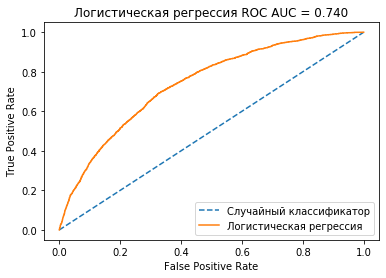

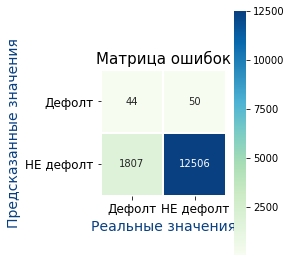

In [98]:
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Низкий процент прогноза по дефолтным клиентам. Низкое значение полноты указывает на несовершенность модели

## 2. Модель с гиперпараметрами

Попробуем применить гиперпараметры

In [99]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
penal = best_model.best_estimator_.get_params()['penalty']
c = best_model.best_estimator_.get_params()['C']

Лучшее Penalty: l1
Лучшее C: 1.0


,Значение,Описание метрики
P,1851.000000,Дефолт
N,12556.000000,БЕЗ дефолта
TP,1291.000000,Истинно дефолтные
TN,8357.000000,Истинно НЕ дефолтные
FP,4199.000000,Ложно дефолтные
FN,560.000000,Ложно НЕ дефолтные
Accuracy,0.669674,Accuracy=(TP+TN)/(P+N)
Precision,0.235155,Точность = TP/(TP+FP)
Recall,0.697461,Полнота = TP/P
F1-score,0.351723,Среднее гармоническое Precision и Recall


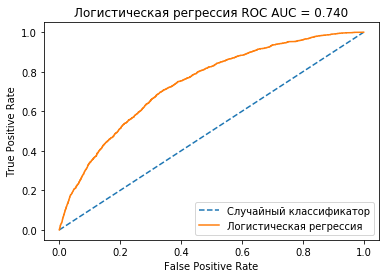

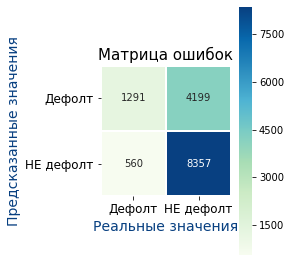

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_test.drop(['app_date', 'client_id'], axis=1, inplace=True)
X_train.drop(['app_date', 'client_id'], axis=1, inplace=True)

# C=166.81
model_2 = LogisticRegression(penalty=penal, C=c, max_iter=50, class_weight ='balanced', tol= 0.001)
model_2.fit(X_train, y_train)

# Предсказываем вероятность и значения целевой переменной
y_pred_prob = model_2.predict_proba(X_test)[:,1]
y_pred = model_2.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)

Модель с гипперпараметрами значительно лучше дефолтных клиентов, но увеличилась ошибка при определении "не дефолтных"

# 3. Полиномиальные признаки, RobastScaler и гиперпараметры

In [101]:
poly = PolynomialFeatures(3)
X_num = poly.fit_transform(train_data[num_cols].values)
X_num_test =poly.fit_transform(test_data[num_cols].values)
# При помощи RobastScaler нормируем числовые данные из тренировочного датасета сразу после разделения 
# и приводим к виду 2-мерного массива

X_num = RobustScaler().fit_transform(X_num)
X_num_test = RobustScaler().fit_transform(X_num_test)
# преобразуем категориальные данные в 2-х мерный массив, наподобие get_dummies
"""По умолчанию OneHotEncoder преобразует данные в разреженную матрицу(sparse = True), чтобы не расходовать память на хранение многочисленных 
нулей. При (sparse = False) вернет массив"""
X_cat = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)
# Объединяем (числовые, двоичные, и категориальные)
X = np.hstack([X_num, train_data[bin_cols].values, X_cat])
Test = np.hstack([X_num_test, test_data[bin_cols].values, X_cat_test])
y = train_data['default'].values

# Разбиваем датасет на тренировочный и тестовый, выделив 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Находим лучшие гиперпараметры
from sklearn.model_selection import GridSearchCV

C = np.logspace(0, 4, 10)
iter_ = 50
epsilon_stop = 1e-3
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,  
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C, 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Лучшее max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Лучшее tol:', best_model.best_estimator_.get_params()['tol'])
penal = best_model.best_estimator_.get_params()['penalty']
c = best_model.best_estimator_.get_params()['C']
max_it = best_model.best_estimator_.get_params()['max_iter']
t = best_model.best_estimator_.get_params()['tol']

Лучшее Penalty: l2
Лучшее C: 59.94842503189409
Лучшее max_iter: 50
Лучшее tol: 0.001


,Значение,Описание метрики
P,1851.000000,Дефолт
N,12556.000000,БЕЗ дефолта
TP,1266.000000,Истинно дефолтные
TN,8322.000000,Истинно НЕ дефолтные
FP,4234.000000,Ложно дефолтные
FN,585.000000,Ложно НЕ дефолтные
Accuracy,0.665510,Accuracy=(TP+TN)/(P+N)
Precision,0.230182,Точность = TP/(TP+FP)
Recall,0.683955,Полнота = TP/P
F1-score,0.344443,Среднее гармоническое Precision и Recall


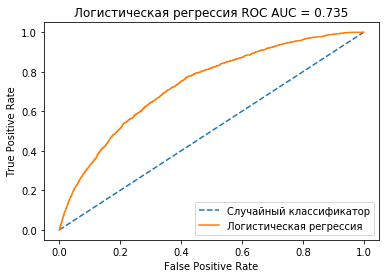

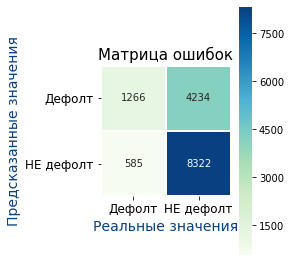

In [102]:
# X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=42)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape
# X_test.drop(['app_date', 'client_id'], axis=1, inplace=True)
# X_train.drop(['app_date', 'client_id'], axis=1, inplace=True)

model_3 = LogisticRegression(penalty=penal, C=c, max_iter=max_it, class_weight ='balanced', tol= t, random_state=42)

model_3.fit(X_train, y_train)

# Предсказываем
y_pred_prob = model_3.predict_proba(X_test)[:,1]
y_pred = model_3.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, y_pred_prob)
show_roc_curve(y_test, y_pred_prob)
show_confusion_matrix(y_test, y_pred)



Применение полиномиальных признаков незначительно ухудшило модель

По ходу работы:
1. Преобразовали education в категориальный признак
2. app_date привели к нормальному виду и получили признак "days"
3. Убрали выбросы переменной income
4. Прологорифмировали числовые признаки
5. Стандартизировали признаки
6. Выделил признак request_difference, указывающий на разницу фактических отказов и запросов в БКИ

# Submission

In [103]:
sample = pd.read_csv('sample_submission.csv')

In [104]:
sample['default'].count()

24354

In [105]:
# test_for_sub = df.query('train == 0').drop(['train'], axis=1)
# id_test = test_for_sub.client_id
test_for_sub.drop(['app_date', 'client_id','default'], axis=1, inplace=True)

pred_prob_submission = model_2.predict_proba(test_for_sub)[:,1]

submission = pd.DataFrame({'client_id': id_test, 
                            'default': pred_prob_submission})
submission.to_csv('submission.csv', index=False)
submission

,client_id,default
73799,74835,0.221866
73800,17527,0.790043
73801,75683,0.359459
73802,26883,0.396554
73803,28862,0.128911
...,...,...
110143,83775,0.778817
110144,106254,0.110417
110145,81852,0.770191
110146,1971,0.718089


In [106]:
test_for_sub.shape

(36349, 18)

In [107]:
id_test.shape

(36349,)